# 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


# 2

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 60352432.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 3

In [3]:
class NetStandard(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NetStandard, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout_rate = dropout_rate

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class Net(nn.Module):
    def __init__(self, dropout_start=0.5, dropout_end=0.1, total_epochs=50):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout_start = dropout_start
        self.dropout_end = dropout_end
        self.total_epochs = total_epochs

    def forward(self, x, epoch):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dynamic_dropout(x, epoch)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def dynamic_dropout(self, x, epoch):
        p = self.get_dropout_rate(epoch)
        return F.dropout(x, p=p, training=self.training)

    def get_dropout_rate(self, epoch):
        return self.dropout_start - (self.dropout_start - self.dropout_end) * (epoch / self.total_epochs)



# 4

In [4]:
def train_and_record_errors(net, trainloader, testloader, criterion, optimizer, num_epochs=50, decay=False):
    train_errors = []
    test_errors = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            if decay:
                outputs = net(inputs, epoch)
            else:
                outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate train and test error
        train_error = calculate_classification_error(net, trainloader, epoch, decay)
        test_error = calculate_classification_error(net, testloader, epoch, decay)

        train_errors.append(train_error)
        test_errors.append(test_error)

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Train Error: {train_error}, Test Error: {test_error}')

    return train_errors, test_errors

def calculate_classification_error(net, dataloader, epoch, decay):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            if decay:
                outputs = net(images, epoch)
            else:
                outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    error = 1 - (correct / total)
    return error


# 5

In [6]:
net_standard = NetStandard()
criterion = nn.CrossEntropyLoss()
optimizer_standard = optim.SGD(net_standard.parameters(), lr=0.001, momentum=0.9)
train_errors_standard, test_errors_standard = train_and_record_errors(net_standard, trainloader, testloader, criterion, optimizer_standard, num_epochs=50, decay=False)

net_decay = Net(dropout_start=0.5, dropout_end=0.1, total_epochs=50)
optimizer_decay = optim.SGD(net_decay.parameters(), lr=0.001, momentum=0.9)
train_errors_decay, test_errors_decay = train_and_record_errors(net_decay, trainloader, testloader, criterion, optimizer_decay, num_epochs=50, decay=True)
epochs = range(1, 51)


Epoch 1, Loss: 2.302831085205078, Train Error: 0.86164, Test Error: 0.8646
Epoch 2, Loss: 2.2945587248802184, Train Error: 0.83346, Test Error: 0.8334
Epoch 3, Loss: 2.240999855041504, Train Error: 0.77338, Test Error: 0.7689
Epoch 4, Loss: 2.1090309216976166, Train Error: 0.73758, Test Error: 0.7337
Epoch 5, Loss: 2.000893122673035, Train Error: 0.70226, Test Error: 0.6999
Epoch 6, Loss: 1.8998015277385711, Train Error: 0.6614800000000001, Test Error: 0.6593
Epoch 7, Loss: 1.7919781305789948, Train Error: 0.6235200000000001, Test Error: 0.6209
Epoch 8, Loss: 1.7265228078365327, Train Error: 0.6058, Test Error: 0.6061000000000001
Epoch 9, Loss: 1.6770508029460907, Train Error: 0.5908599999999999, Test Error: 0.5892
Epoch 10, Loss: 1.643621720790863, Train Error: 0.57294, Test Error: 0.5761000000000001
Epoch 11, Loss: 1.609567876815796, Train Error: 0.5575600000000001, Test Error: 0.5576
Epoch 12, Loss: 1.5812957823276519, Train Error: 0.54108, Test Error: 0.5465
Epoch 13, Loss: 1.55131

# 6

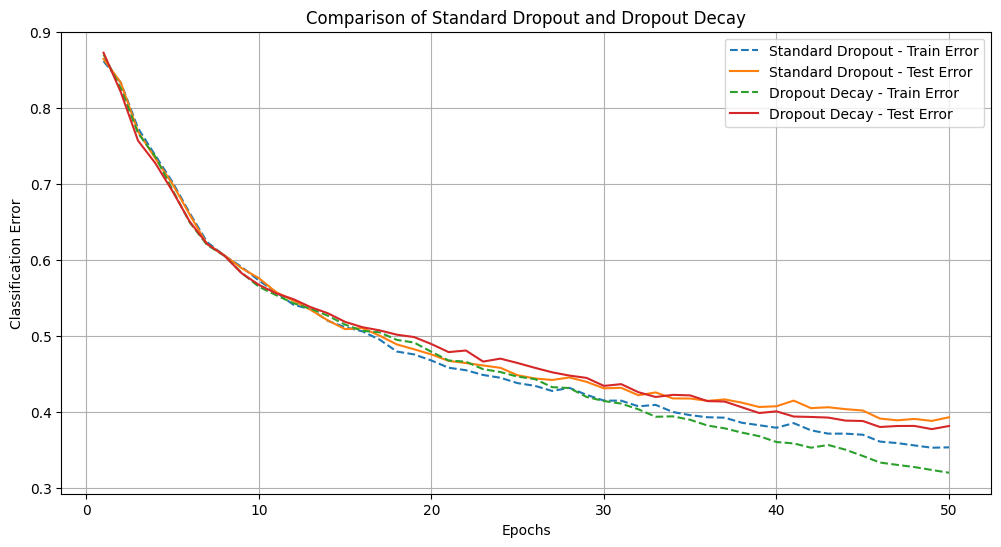

In [7]:


plt.figure(figsize=(12, 6))
plt.plot(epochs, train_errors_standard, label='Standard Dropout - Train Error', linestyle='--')
plt.plot(epochs, test_errors_standard, label='Standard Dropout - Test Error')
plt.plot(epochs, train_errors_decay, label='Dropout Decay - Train Error', linestyle='--')
plt.plot(epochs, test_errors_decay, label='Dropout Decay - Test Error')

plt.xlabel('Epochs')
plt.ylabel('Classification Error')
plt.title('Comparison of Standard Dropout and Dropout Decay')
plt.legend()
plt.grid(True)
plt.show()
